In [81]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import  torchvision.datasets
import torchvision.models as models
import torchvision.transforms as tf
from torchvision.datasets import DatasetFolder, ImageFolder
from torch.utils.data import DataLoader


# %matplotlib inline

# VGG19 Mystery Model 2

This is a Mystery Model, which is essentially utilizing pre-trained model of VGG19 for feature extraction, and then utilizing a MLP for classification. We are trying to determine if we can reduce overfitting on small dataset as compared to original VGG19 model

__note__ = Make sure to run the model before running the training set, in order to rest the model properly

In [82]:

def get_accuracy(model, data):
    '''
    @model: The model we are running training accuracy on.
    @data: A batch of images to check the accuracy
    @return: The probability of accuracy
    '''

    loader = torch.utils.data.DataLoader(data, batch_size=32)
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in loader:
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, train_data, batch_size=32, weight_decay=0.0,
          learning_rate=0.001, num_epochs=10, checkpoint_path=None,
          valid_data = None):
    '''
    @model: The MLP model we are training
    @batch_size: The batch size to use
    @weight_decay: The weight decay parameter for Adam optimizer
    @learning rate: The learning rate for the adam optimizer
    @nnum_epochs: The number of epochs to run
    '''

    # load the train data
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)



    # defining loss function and optimizer, using ADAM
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    # keeping track of training acc and val_acc
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            model.train()

            # forward pass and backward pass
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            # zero the gradient parameter
            optimizer.zero_grad()
            n += 1

        # calculating loss and accuracy
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data)

        if (valid_data!= None):
            vacc = get_accuracy(model, valid_data)
            print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (n, loss, tacc, vacc))
            val_acc.append(vacc)
        else:
            print("Iter %d; Loss %f; Train Acc %.3f;" % (n, loss, tacc))

        iters.append(n)
        losses.append(loss)
        train_acc.append(tacc)

        # creating checkpoint for saving the model
        if (checkpoint_path is not None) and epoch % 10 == 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))
        # val_acc.append(vacc)

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    if (valid_data!=None):
        plt.plot(iters, val_acc, label="Test")

    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    PATH = './cifar_net.pth'+ model.name
    torch.save(model.state_dict(), PATH)

    print("Final Training Accuracy: {}".format(train_acc[-1]))


In [83]:
# function to show an image (taken from TUT09)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.ion()
    plt.show()

# pre-trained vgg19 model
vgg19 = models.vgg19(pretrained=True)

def dataPreparation(path, batchsize, imagesize, pathTest, validTest = None):
    transform = tf.Compose([tf.RandomHorizontalFlip(),
                            tf.ToTensor(),
                            tf.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    trainingdata= ImageFolder(root=path, transform=transform)
    testdata= ImageFolder(root=pathTest, transform=transform)
    trainloader = DataLoader(dataset=trainingdata, batch_size= batchsize, shuffle=True)
    classes_ = trainingdata.classes

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # show images
    imshow(torchvision.utils.make_grid(images))

    validdata = None
    if (validTest != None):
        validdata= ImageFolder(root=validTest, transform=transform)

    # print labels
    print(' '.join('%5s' % classes_[labels[j]] for j in range(4)))

    return trainingdata, testdata, validdata

In [84]:
# MLP to divide output from VGG19 weights
class MLP(nn.Module):
    def __init__(self, NumberOfUniqueClasses):
        super(MLP, self).__init__()
        self.name = "MLP"
        self.layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100,NumberOfUniqueClasses)
        )


    def forward(self, x):
        x = x.view(-1, 512 * 7 * 7)
        x = self.layers(x)
        return x

# Running model on Tumor Dataset

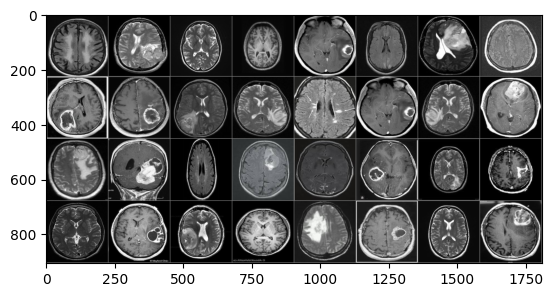

   no   yes    no    no


Dataset ImageFolder
    Number of datapoints: 202
    Root location: ./data/tumor/train/
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [85]:
traindata, testdata, validdata = dataPreparation(path="./data/tumor/train/", batchsize=32,imagesize=64, pathTest="./data/tumor/test/")
traindata

In [86]:
train_data_features = []
i = 0
for img, y in traindata:
    features = vgg19.features(img.unsqueeze(0)).detach()  # compute the VGG19 features based on the image
    train_data_features.append((features, y),)

testdata_features = []
for img, y in testdata:
    features = vgg19.features(img.unsqueeze(0)).detach()  # compute the VGG19 features based on the image
    testdata_features.append((features, y),)

In [87]:
mlp = MLP(2)

Iter 7; Loss 0.007027; Train Acc 0.916; Val Acc 0.900
Iter 14; Loss 0.003309; Train Acc 0.970; Val Acc 0.860
Iter 21; Loss 0.000262; Train Acc 0.975; Val Acc 0.940
Iter 28; Loss 0.000149; Train Acc 0.995; Val Acc 0.880
Iter 35; Loss 0.000089; Train Acc 1.000; Val Acc 0.940
Iter 42; Loss 0.000241; Train Acc 1.000; Val Acc 0.940
Iter 49; Loss 0.000066; Train Acc 1.000; Val Acc 0.900
Iter 56; Loss 0.000076; Train Acc 1.000; Val Acc 0.960
Iter 63; Loss 0.000067; Train Acc 1.000; Val Acc 0.920
Iter 70; Loss 0.000040; Train Acc 1.000; Val Acc 0.960
Iter 77; Loss 0.000067; Train Acc 1.000; Val Acc 0.960
Iter 84; Loss 0.000014; Train Acc 1.000; Val Acc 0.960
Iter 91; Loss 0.000029; Train Acc 1.000; Val Acc 0.940
Iter 98; Loss 0.000020; Train Acc 1.000; Val Acc 0.940
Iter 105; Loss 0.000011; Train Acc 1.000; Val Acc 0.940
Iter 112; Loss 0.000019; Train Acc 1.000; Val Acc 0.940
Iter 119; Loss 0.000009; Train Acc 1.000; Val Acc 0.940
Iter 126; Loss 0.000015; Train Acc 1.000; Val Acc 0.940
Iter 13

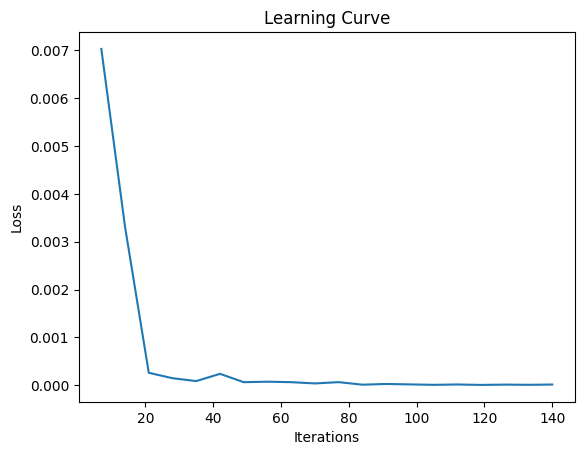

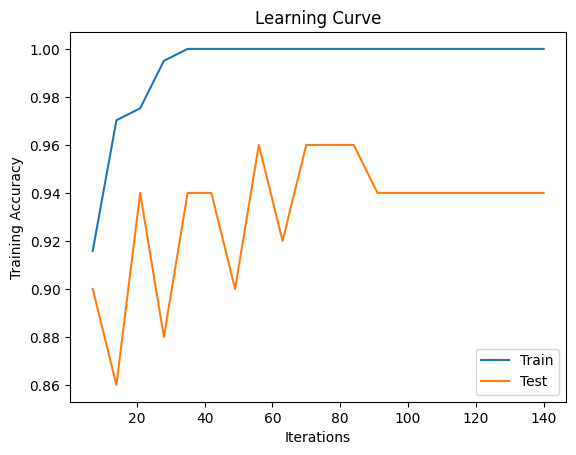

Final Training Accuracy: 1.0


In [88]:
train(mlp, train_data_features, batch_size=32 ,num_epochs=20, valid_data=testdata_features)

In [89]:
 def TestModel(net, testdata):
    # display images from test set
    test_loader = torch.utils.data.DataLoader(testdata,
                                              batch_size=4,
                                              shuffle=True)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 216 test images: %d %%' % (
            100 * correct / total))

TestModel(mlp, testdata_features)

Accuracy of the network on the 216 test images: 94 %


# Running the mystery model on asl dataset

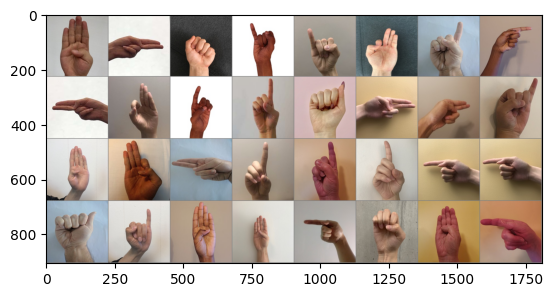

    B     H     A     I


In [90]:
traindata, testdata, validdata = dataPreparation(path="./data/asl_data/train/", batchsize=32,imagesize=32, pathTest="./data/asl_data/test/", validTest="./data/asl_data/valid/")

train_data_features = []
i = 0
for img, y in traindata:
    features = vgg19.features(img.unsqueeze(0)).detach()  # compute the VGG19 features based on the image
    train_data_features.append((features, y),)

valid_data_features = []
i = 0
for img, y in validdata:
    features = vgg19.features(img.unsqueeze(0)).detach()  # compute the VGG19 features based on the image
    valid_data_features.append((features, y),)

testdata_features = []
for img, y in testdata:
    features = vgg19.features(img.unsqueeze(0)).detach()  # compute the VGG19 features based on the image
    testdata_features.append((features, y),)

Iter 23; Loss 0.013069; Train Acc 0.936; Val Acc 0.695
Iter 46; Loss 0.004244; Train Acc 0.986; Val Acc 0.740
Iter 69; Loss 0.000423; Train Acc 1.000; Val Acc 0.762
Iter 92; Loss 0.000925; Train Acc 1.000; Val Acc 0.744
Iter 115; Loss 0.000280; Train Acc 1.000; Val Acc 0.753
Iter 138; Loss 0.000132; Train Acc 1.000; Val Acc 0.749
Iter 161; Loss 0.000076; Train Acc 1.000; Val Acc 0.758
Iter 184; Loss 0.000089; Train Acc 1.000; Val Acc 0.753
Iter 207; Loss 0.000098; Train Acc 1.000; Val Acc 0.753
Iter 230; Loss 0.000126; Train Acc 1.000; Val Acc 0.758
Iter 253; Loss 0.000035; Train Acc 1.000; Val Acc 0.753
Iter 276; Loss 0.000040; Train Acc 1.000; Val Acc 0.753
Iter 299; Loss 0.000032; Train Acc 1.000; Val Acc 0.753
Iter 322; Loss 0.000070; Train Acc 1.000; Val Acc 0.758
Iter 345; Loss 0.000026; Train Acc 1.000; Val Acc 0.758
Iter 368; Loss 0.000033; Train Acc 1.000; Val Acc 0.753
Iter 391; Loss 0.000040; Train Acc 1.000; Val Acc 0.758
Iter 414; Loss 0.000030; Train Acc 1.000; Val Acc 0.

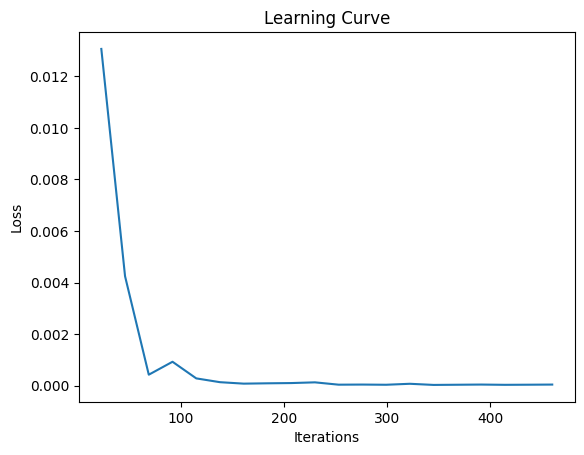

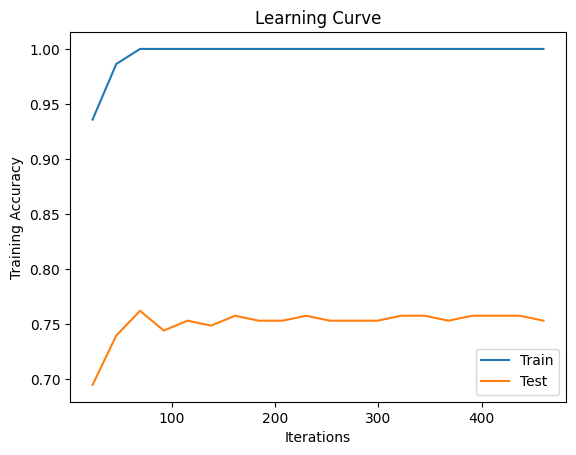

Final Training Accuracy: 1.0


In [91]:
mlp = MLP(9)
train(mlp, train_data_features, batch_size=32 ,num_epochs=20, valid_data=testdata_features)

In [76]:
TestModel(mlp, testdata_features)

Accuracy of the network on the 216 test images: 77 %
